### **Import libraries and packages, define functions**

In [734]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings as wg
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from scipy.stats import binom
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

wg.filterwarnings('ignore')

The function below allows us to format to format the values adding an 'M' that stands for millions or 'T' for thousands, for better visibility.

In [735]:
def millions_formatter(x, pos):
    return f'{x / 1e6} M'

def thousands_formatter(x, pos):
    return f'{x / 1e3} K'

def standard_decimal_notation_formatter(x):
    return '{:.2f}'.format(x)

### **1. Load and import datasets**

In [736]:
# Main datasets
#population_df = pd.read_csv('PEA11.20231013T111046.csv')
#migration_df = pd.read_csv('PEA18.20231016T141007.csv')

#Cleaned datasets
#population_df_clean = pd.read_csv('population_df.csv')
#migration_df_clean = pd.read_csv('migration_df.csv')
population_df_1996 = pd.read_csv('population_df_1996.csv')
migration_df_1996 = pd.read_csv('migration_df_1996.csv')

Creating age groups to see population distribution by age

In [737]:
population_age_breakdown_df = population_df_1996[(population_df_1996['Single Year of Age'] != 'All ages') & (population_df_1996['Year'] > 2012) & (population_df_1996['Sex'] == 'Both sexes')]
population_age_breakdown_df = population_age_breakdown_df.drop(['Sex category', 'Sex'], axis=1)
population_age_breakdown_df

,Year,Age category,Single Year of Age,UNIT,VALUE
5154,2013,200,Under 1 year,Number,68583
5157,2013,001,1 year,Number,71785
5160,2013,002,2 years,Number,70638
5163,2013,003,3 years,Number,71057
5166,2013,004,4 years,Number,70956
...,...,...,...,...,...
8469,2023,095,95 years,Number,2128
8472,2023,096,96 years,Number,1581
8475,2023,097,97 years,Number,1116
8478,2023,098,98 years,Number,829


In [738]:
try:
    population_age_breakdown_df['Single Year of Age'] = population_age_breakdown_df['Single Year of Age'].replace('Under 1 year', '0 year')
    output = population_age_breakdown_df.head()
except Exception as e:
    output = f"An error occurred: {e}"

output

,Year,Age category,Single Year of Age,UNIT,VALUE
5154,2013,200,0 year,Number,68583
5157,2013,001,1 year,Number,71785
5160,2013,002,2 years,Number,70638
5163,2013,003,3 years,Number,71057
5166,2013,004,4 years,Number,70956


In [739]:
population_age_breakdown_df['Single Year of Age'] = population_age_breakdown_df['Single Year of Age'].str.extract(r'(\d+)').astype(int)
population_age_breakdown_df

,Year,Age category,Single Year of Age,UNIT,VALUE
5154,2013,200,0,Number,68583
5157,2013,001,1,Number,71785
5160,2013,002,2,Number,70638
5163,2013,003,3,Number,71057
5166,2013,004,4,Number,70956
...,...,...,...,...,...
8469,2023,095,95,Number,2128
8472,2023,096,96,Number,1581
8475,2023,097,97,Number,1116
8478,2023,098,98,Number,829


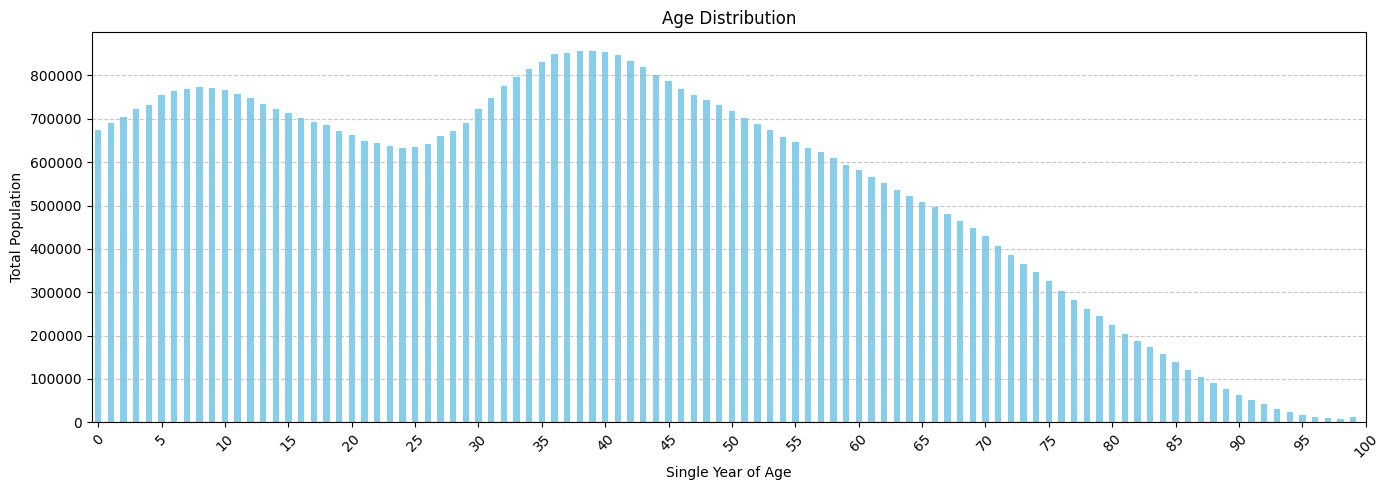

In [740]:

population_age_distribution = population_age_breakdown_df.groupby("Single Year of Age")["VALUE"].sum()

plt.figure(figsize=(14, 5))
population_age_distribution.plot(kind='bar', color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Single Year of Age")
plt.ylabel("Total Population")
plt.xticks(range(0, 101, 5), range(0, 101, 5), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [741]:
weighted_mean = np.average(population_age_breakdown_df["Single Year of Age"], weights=population_age_breakdown_df["VALUE"])

weighted_variance = np.average((population_age_breakdown_df["Single Year of Age"] - weighted_mean)**2, weights=population_age_breakdown_df["VALUE"])
weighted_std = np.sqrt(weighted_variance)

sorted_df = population_age_breakdown_df.sort_values(by="Single Year of Age")
cumsum = sorted_df["VALUE"].cumsum()
cutoff = cumsum.iloc[-1] / 2.0
weighted_median = sorted_df[sorted_df["VALUE"].cumsum() >= cutoff]["Single Year of Age"].iloc[0]

print(f"Variance: {weighted_variance}")
print(f"Mean: {weighted_mean:.8f}")
print(f"Median: {weighted_median:.8f}")
print(f"Std: {weighted_std:.8f}")

Variance: 514.1371766441594
Mean: 37.34308988
Median: 37.00000000
Std: 22.67459320


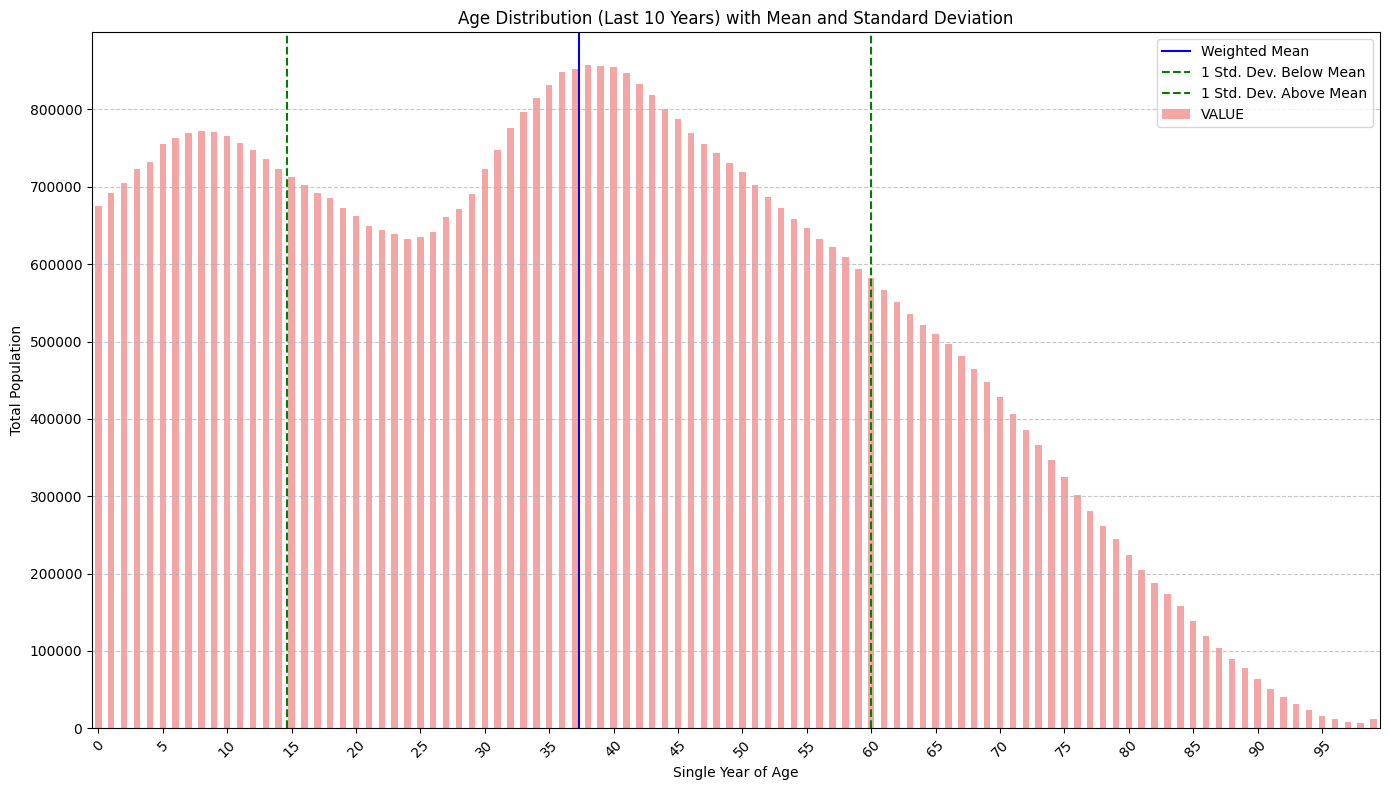

In [742]:
plt.figure(figsize=(14, 8))
population_age_distribution.plot(kind='bar', color='lightcoral', alpha=0.7)
plt.title("Age Distribution (Last 10 Years) with Mean and Standard Deviation")
plt.xlabel("Single Year of Age")
plt.ylabel("Total Population")
plt.xticks(range(0, 100, 5), range(0, 100, 5), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlighting the mean and standard deviation
plt.axvline(x=weighted_mean, color='blue', linestyle='-', label='Weighted Mean')
plt.axvline(x=weighted_mean - weighted_std, color='green', linestyle='--', label='1 Std. Dev. Below Mean')
plt.axvline(x=weighted_mean + weighted_std, color='green', linestyle='--', label='1 Std. Dev. Above Mean')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [743]:
def age_group(age):
    if age <= 14:
        return '0-14 years old'
    elif age <= 24:
        return '15-24 years old'
    elif age <= 44:
        return '25-44 years old'
    elif age <= 64:
        return '45-64 years old'
    else:
        return '65 and over'

population_age_breakdown_df['Age Group'] = population_age_breakdown_df['Single Year of Age'].apply(age_group)

population_age_breakdown_df


,Year,Age category,Single Year of Age,UNIT,VALUE,Age Group
5154,2013,200,0,Number,68583,0-14 years old
5157,2013,001,1,Number,71785,0-14 years old
5160,2013,002,2,Number,70638,0-14 years old
5163,2013,003,3,Number,71057,0-14 years old
5166,2013,004,4,Number,70956,0-14 years old
...,...,...,...,...,...,...
8469,2023,095,95,Number,2128,65 and over
8472,2023,096,96,Number,1581,65 and over
8475,2023,097,97,Number,1116,65 and over
8478,2023,098,98,Number,829,65 and over


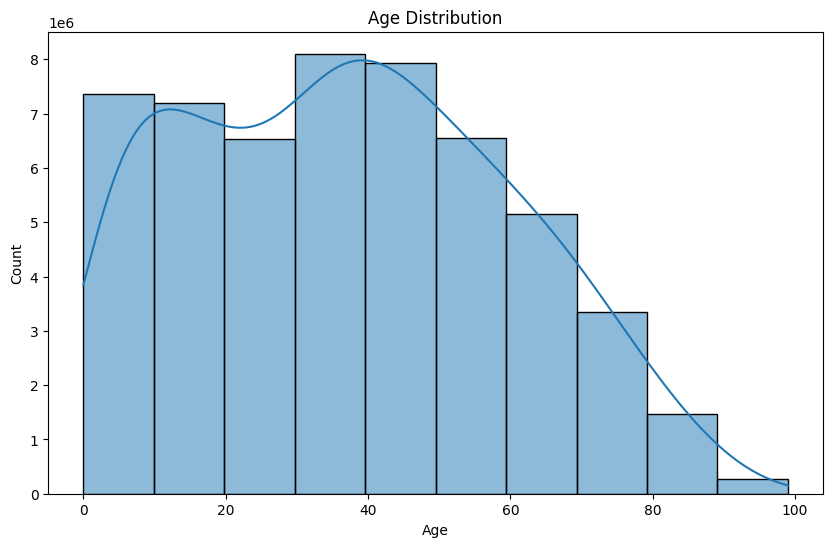

In [744]:
plt.figure(figsize=(10, 6))
sns.histplot(data=population_age_breakdown_df, x='Single Year of Age', weights='VALUE', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [745]:
population_age_breakdown_df

,Year,Age category,Single Year of Age,UNIT,VALUE,Age Group
5154,2013,200,0,Number,68583,0-14 years old
5157,2013,001,1,Number,71785,0-14 years old
5160,2013,002,2,Number,70638,0-14 years old
5163,2013,003,3,Number,71057,0-14 years old
5166,2013,004,4,Number,70956,0-14 years old
...,...,...,...,...,...,...
8469,2023,095,95,Number,2128,65 and over
8472,2023,096,96,Number,1581,65 and over
8475,2023,097,97,Number,1116,65 and over
8478,2023,098,98,Number,829,65 and over


In [746]:
population_pivot_age_groups = population_age_breakdown_df.pivot_table(index='Year', columns='Age Group', values='VALUE', aggfunc='sum')

population_pivot_age_groups = population_pivot_age_groups.reset_index()
population_pivot_age_groups.columns.name = None
population_pivot_age_groups

,Year,0-14 years old,15-24 years old,25-44 years old,45-64 years old,65 and over
0,2013,993909,563278,1421081,1067215,569186
1,2014,997516,567222,1407323,1083895,589484
2,2015,1001705,571610,1400611,1103591,610270
3,2016,1005484,574697,1401520,1128049,629847
4,2017,1010356,587014,1403256,1157861,652408
5,2018,1014430,609252,1402768,1182019,676427
6,2019,1015539,623805,1406012,1211743,701372
7,2020,1013651,637923,1412015,1240171,726115
8,2021,1007602,640355,1411903,1267359,747449
9,2022,1014292,649717,1434196,1304462,781299


#### Binomial distribution

In [747]:
binom_pop_dataset = population_pivot_age_groups[population_pivot_age_groups['Year'] == 2022]
binom_pop_dataset

,Year,0-14 years old,15-24 years old,25-44 years old,45-64 years old,65 and over
9,2022,1014292,649717,1434196,1304462,781299


In [748]:
probability_0_14= binom_pop_dataset['0-14 years old'].values[0] / 5185988

probability_0_14

0.1955831752792332

In [749]:
n = 100
k = 20
p = probability_0_14  

probability = binom.pmf(k, n, p)
print(probability)

0.0986899218478517


Using the binomial distribution, the function provides the probability of getting exactly 20 successes (people from the 0-14 age group) when conducting 100 trials (selecting 100 people).

https://homepage.divms.uiowa.edu/~mbognar/applets/bin.html -- binomial distribution calculator

![binomial distribution](imgs/binom_calc.png)


Growth Rate=(Current Year Population - Previous Year Population / Previous Year Population)×100

In [750]:
growth_rates_df = population_pivot_age_groups.set_index('Year').pct_change() * 100

growth_rates_df = growth_rates_df.reset_index()
growth_rates_df

,Year,0-14 years old,15-24 years old,25-44 years old,45-64 years old,65 and over
0,2013,NaN,NaN,NaN,NaN,NaN
1,2014,0.362910,0.700187,-0.968136,1.562947,3.566145
2,2015,0.419943,0.773595,-0.476934,1.817150,3.526135
3,2016,0.377257,0.540054,0.064900,2.216220,3.207924
4,2017,0.484543,2.143216,0.123866,2.642793,3.581981
5,2018,0.403224,3.788325,-0.034776,2.086434,3.681592
6,2019,0.109322,2.388667,0.231257,2.514680,3.687759
7,2020,-0.185911,2.263207,0.426952,2.346042,3.527800
8,2021,-0.596754,0.381237,-0.007932,2.192278,2.938102
9,2022,0.663953,1.462002,1.578933,2.927584,4.528737


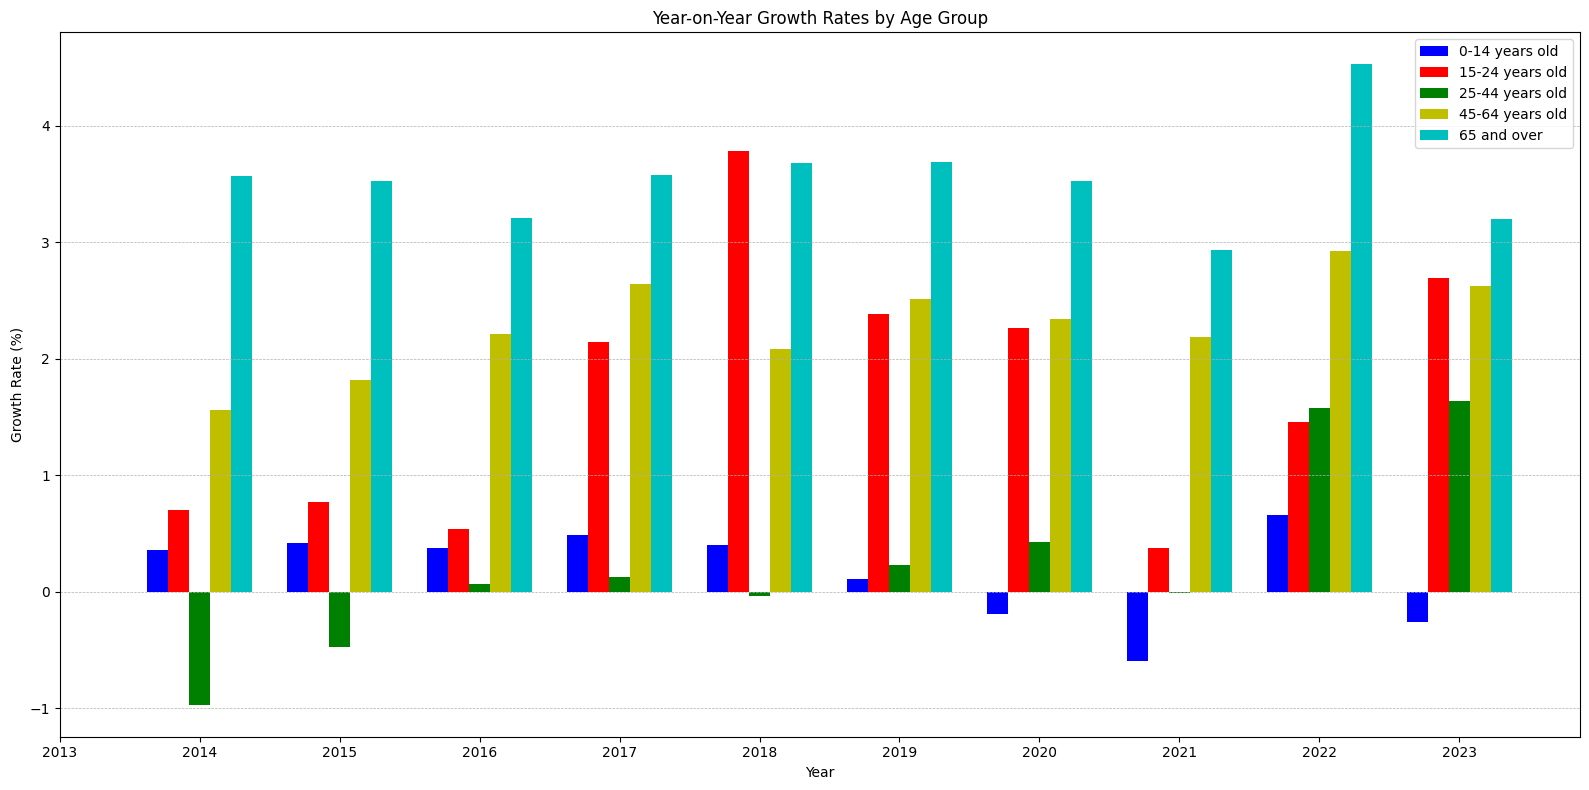

In [751]:
bar_width = 0.15
years = growth_rates_df['Year']
index = range(len(years))
colors = ['b', 'r', 'g', 'y', 'c']

plt.figure(figsize=(16, 8))

for idx, column in enumerate(growth_rates_df.columns[1:]):
    plt.bar(
        [i + idx * bar_width for i in index],
        growth_rates_df[column],
        width=bar_width,
        label=column,
        color=colors[idx]
    )

plt.title('Year-on-Year Growth Rates by Age Group')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.xticks([i + 2 * bar_width for i in index], years)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

In [752]:
population_pivot_age_groups['Total Population'] = population_pivot_age_groups.sum(axis=1)

population_pivot_age_groups['Total Growth Rate'] = population_pivot_age_groups['Total Population'].pct_change() * 100

population_pivot_age_groups[['Year', 'Total Population', 'Total Growth Rate']]


,Year,Total Population,Total Growth Rate
0,2013,4616682,NaN
1,2014,4647454,0.666539
2,2015,4689802,0.911209
3,2016,4741613,1.104759
4,2017,4812912,1.503687
5,2018,4886914,1.537572
6,2019,4960490,1.505572
7,2020,5031895,1.439475
8,2021,5076689,0.890201
9,2022,5185988,2.152958


In [753]:
max_growth_year = population_pivot_age_groups.loc[population_pivot_age_groups['Total Growth Rate'].idxmax(), 'Year']
min_growth_year = population_pivot_age_groups.loc[population_pivot_age_groups['Total Growth Rate'].idxmin(), 'Year']
highest_growth_rate = population_pivot_age_groups['Total Growth Rate'].max()
lowest_growth_rate = population_pivot_age_groups['Total Growth Rate'].min()

dominant_age_groups = growth_rates_df.drop(columns='Year').idxmax(axis=1)

aligned_growth_rates_df, aligned_total_growth = growth_rates_df.set_index('Year').align(
    population_pivot_age_groups.set_index('Year')['Total Growth Rate'], axis=1)

age_groups_above_total = (aligned_growth_rates_df > aligned_total_growth).sum()
age_groups_below_total = (aligned_growth_rates_df < aligned_total_growth).sum()

growth_rate_std = growth_rates_df.drop(columns='Year').std()

print(f"Year with maximum growth: {max_growth_year} with a growth rate of: {highest_growth_rate:.6f}")
print(f"Year with minimum growth: {min_growth_year} with a growth rate of: {lowest_growth_rate:.6f}\n")

print("Dominant age groups by year:")
for year, age_group in dominant_age_groups.items():
    print(f"  {year}: {age_group}")

Year with maximum growth: 2022 with a growth rate of: 2.152958
Year with minimum growth: 2014 with a growth rate of: 0.666539

Dominant age groups by year:
  0: nan
  1: 65 and over
  2: 65 and over
  3: 65 and over
  4: 65 and over
  5: 15-24 years old
  6: 65 and over
  7: 65 and over
  8: 65 and over
  9: 65 and over
  10: 65 and over


In [754]:
print("Number of age groups above the total growth rate by year:")
for year, count in age_groups_above_total.items():
    print(f"  {year}: {count}")

Number of age groups above the total growth rate by year:
  0-14 years old: 0
  15-24 years old: 0
  25-44 years old: 0
  45-64 years old: 0
  65 and over: 0
  2013: 0
  2014: 0
  2015: 0
  2016: 0
  2017: 0
  2018: 0
  2019: 0
  2020: 0
  2021: 0
  2022: 0
  2023: 0


In [755]:
print("Number of age groups below the total growth rate by year:")
for year, count in age_groups_below_total.items():
    print(f"  {year}: {count}")

Number of age groups below the total growth rate by year:
  0-14 years old: 0
  15-24 years old: 0
  25-44 years old: 0
  45-64 years old: 0
  65 and over: 0
  2013: 0
  2014: 0
  2015: 0
  2016: 0
  2017: 0
  2018: 0
  2019: 0
  2020: 0
  2021: 0
  2022: 0
  2023: 0


In [756]:
print("Standard deviation of the growth rate across age groups:")
for age_group, std_value in growth_rate_std.items():
    print(f"  {age_group}: {std_value:.6f}")

Standard deviation of the growth rate across age groups:
  0-14 years old: 0.400539
  15-24 years old: 1.122137
  25-44 years old: 0.812438
  45-64 years old: 0.409218
  65 and over: 0.423033


**Overall Population Growth:**

The year with the highest overall growth rate was 2022, with a growth rate of approximately 
2.15
%
2.15%.
The year with the lowest overall growth rate was 2014, with a growth rate of approximately 
0.67
%
0.67%.
Age Group Dominance:

The "65 and over" age group had the highest growth rate in most of the years. This suggests that the elderly population has been growing at a faster rate than other age groups in many years.
Comparison with Overall Growth:

It appears that there's an issue with our comparison method, as it shows none of the age groups being above or below the total growth rate. This might be due to the structure of our data or the method of comparison. We'll need to re-evaluate this.
Stable and Unstable Growth:

The "45-64 years old" and "65 and over" age groups have shown relatively stable growth rates with a standard deviation of approximately 
0.41
%
0.41% and 
0.42
%
0.42%, respectively.
The "15-24 years old" age group has shown the most volatile growth with the highest standard deviation of approximately 
1.12
%
1.12%.
Would you like me to further investigate the comparison with overall growth, or any other specific insights or analyses?​

In [757]:
total_growth_trend = population_pivot_age_groups['Total Growth Rate'].dropna().diff().mean()

age_group_contributions = population_pivot_age_groups.drop(columns=['Year', 'Total Population', 'Total Growth Rate']).diff().sum()

age_group_trends = growth_rates_df.drop(columns='Year').mean()

most_volatile_age_group = growth_rate_std.idxmax()
least_volatile_age_group = growth_rate_std.idxmin()

print(f"Yearly total growth trend: {total_growth_trend:.6f}")

print("\nAge group contributions:")
for group, contribution in age_group_contributions.items():
    print(f"{group}: {contribution:.1f}")

print("\nAge group trends:")
for group, trend in age_group_trends.items():
    print(f"{group}: {trend:.6f}")

print(f"\nMost volatile age group: {most_volatile_age_group}")
print(f"Least volatile age group: {least_volatile_age_group}")

Yearly total growth trend: 0.135151

Age group contributions:
0-14 years old: 17730.0
15-24 years old: 103937.0
25-44 years old: 36642.0
45-64 years old: 271524.0
65 and over: 237110.0

Age group trends:
0-14 years old: 0.177693
15-24 years old: 1.713366
25-44 years old: 0.257856
45-64 years old: 2.293380
65 and over: 3.544559

Most volatile age group: 15-24 years old
Least volatile age group: 0-14 years old


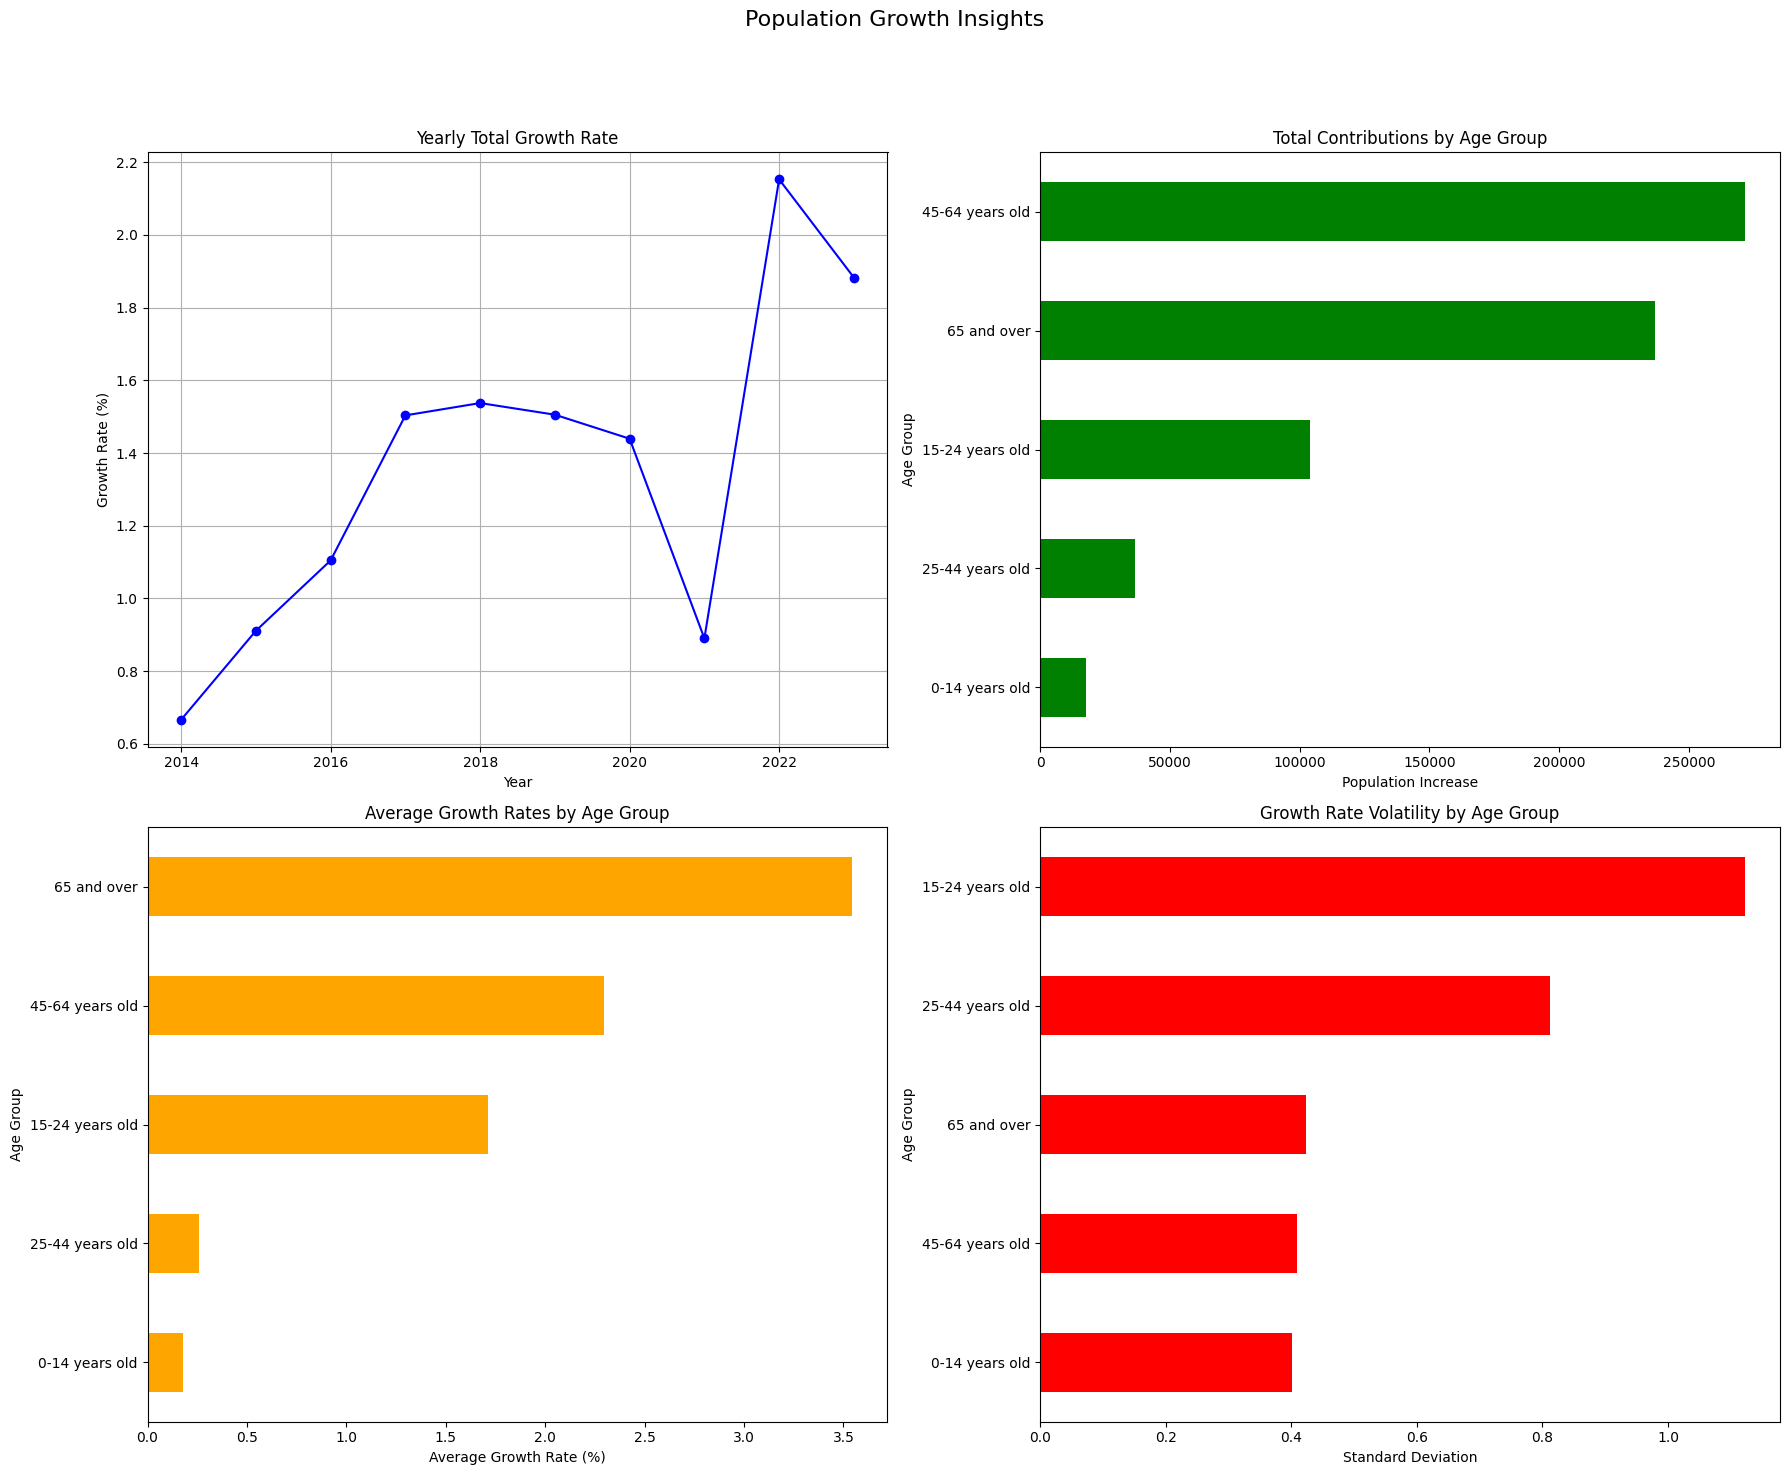

In [758]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
fig.suptitle('Population Growth Insights', fontsize=16, y=1.05)

# Line plot of yearly total growth rate
axes[0, 0].plot(population_pivot_age_groups['Year'], population_pivot_age_groups['Total Growth Rate'], marker='o', color='blue')
axes[0, 0].set_title('Yearly Total Growth Rate')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Growth Rate (%)')
axes[0, 0].grid(True)

# Bar plot of age group contributions
age_group_contributions.sort_values().plot(kind='barh', ax=axes[0, 1], color='green')
axes[0, 1].set_title('Total Contributions by Age Group')
axes[0, 1].set_xlabel('Population Increase')
axes[0, 1].set_ylabel('Age Group')

# Bar plot of average growth rates by age group
age_group_trends.sort_values().plot(kind='barh', ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Average Growth Rates by Age Group')
axes[1, 0].set_xlabel('Average Growth Rate (%)')
axes[1, 0].set_ylabel('Age Group')

# Bar plot of growth rate volatility
growth_rate_std.sort_values().plot(kind='barh', ax=axes[1, 1], color='red')
axes[1, 1].set_title('Growth Rate Volatility by Age Group')
axes[1, 1].set_xlabel('Standard Deviation')
axes[1, 1].set_ylabel('Age Group')

plt.tight_layout()
plt.show()

**Yearly Total Growth Analysis:**

The average change in the yearly total growth rate is approximately 
0.135
%
0.135%. This value indicates the average yearly change in the growth rate. Since it's positive, it suggests that the growth rate has been increasing on average year over year, but the magnitude of the change is relatively small.
Age Group Impact:

The "45-64 years old" age group has contributed the most to the total population growth with an increase of approximately 271,524 people over the years.
The "65 and over" age group follows closely with an increase of approximately 237,110 people.
The "0-14 years old" age group has had the least contribution to growth with only an increase of about 17,730 people.
Age Group Trends:

On average, the "65 and over" age group has the highest growth rate at approximately 
3.54
%
3.54%.
The "15-24 years old" age group follows with an average growth rate of approximately 
1.71
%
1.71%.
The "0-14 years old" age group has the lowest average growth rate at around 
0.18
%
0.18%.
Volatile Age Groups:

The "15-24 years old" age group has shown the most fluctuation in its growth rate over the years, as indicated by its highest standard deviation.
The "0-14 years old" age group has the least variability in its growth rates, making it the most stable.

Migration data visualizations

In [759]:
immigration_df = migration_df[(migration_df['Origin or Destination'] == 'Immigrants: All origins') & (migration_df['Sex'] == 'Both sexes') & (migration_df['Year'] >= 2015) & (migration_df['Country'] != 'All countries')]
immigration_df

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02719V03286,Country,C02199V02655,Sex,C02542V03077,Origin or Destination,UNIT,VALUE
2018,PEA18,Estimated Migration (Persons in April),2015,2015,GB1,United Kingdom (1),-,Both sexes,5,Immigrants: All origins,Thousand,16.4
2027,PEA18,Estimated Migration (Persons in April),2015,2015,US,United States,-,Both sexes,5,Immigrants: All origins,Thousand,4.4
2036,PEA18,Estimated Migration (Persons in April),2015,2015,CA,Canada,-,Both sexes,5,Immigrants: All origins,Thousand,2.7
2045,PEA18,Estimated Migration (Persons in April),2015,2015,AU,Australia,-,Both sexes,5,Immigrants: All origins,Thousand,5.8
2054,PEA18,Estimated Migration (Persons in April),2015,2015,ZZWORX23,Other countries (23),-,Both sexes,5,Immigrants: All origins,Thousand,22.8
...,...,...,...,...,...,...,...,...,...,...,...,...
2612,PEA18,Estimated Migration (Persons in April),2023,2023,CA,Canada,-,Both sexes,5,Immigrants: All origins,Thousand,7.2
2621,PEA18,Estimated Migration (Persons in April),2023,2023,AU,Australia,-,Both sexes,5,Immigrants: All origins,Thousand,7.7
2630,PEA18,Estimated Migration (Persons in April),2023,2023,ZZWORX23,Other countries (23),-,Both sexes,5,Immigrants: All origins,Thousand,75.8
2648,PEA18,Estimated Migration (Persons in April),2023,2023,E1420XIE,EU14 excl Irl (UK & Ireland),-,Both sexes,5,Immigrants: All origins,Thousand,17.7


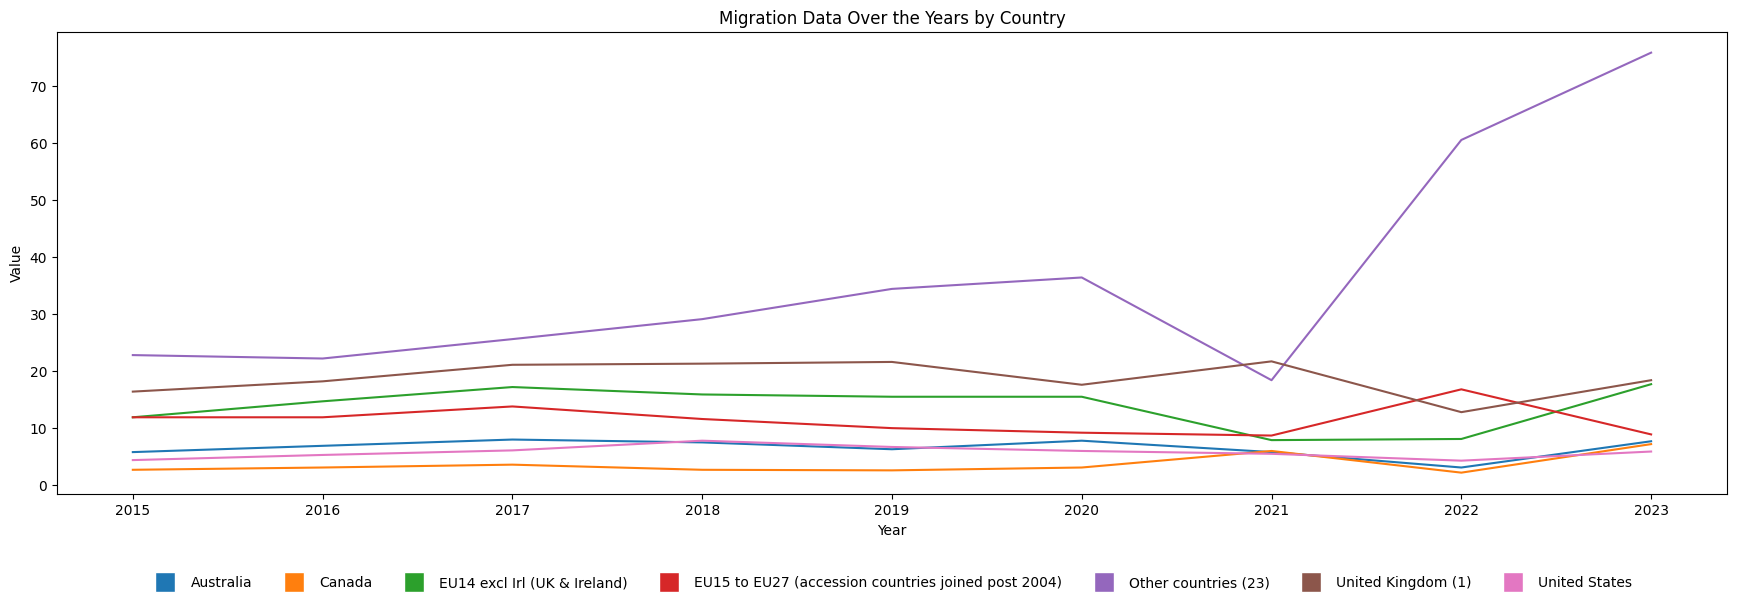

In [760]:
plt.figure(figsize=(21.55, 6))
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
legend_elements = []

pivot_table_immigration = immigration_df.pivot_table(index='Year', columns='Country', values='VALUE', aggfunc= 'sum')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Migration Data Over the Years by Country')

for i, country in enumerate(pivot_table_immigration.columns):
    color = colors[i]
    plt.plot(pivot_table_immigration.index, pivot_table_immigration[country], color, label=country)
    #legend_elements.append(Line2D([0], [0], color=color, label=country))
    legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color,label=country, markersize=15))

plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=8, frameon=False)
plt.show()

In [761]:
immigration_df_all_countries_total = migration_df[(migration_df['Origin or Destination'] == 'Immigrants: All origins') & (migration_df['Sex'] == 'Both sexes') & (migration_df['Year'] >= 2015) & (migration_df['Country'] == 'All countries')]
immigration_df_all_countries_total

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02719V03286,Country,C02199V02655,Sex,C02542V03077,Origin or Destination,UNIT,VALUE
2063,PEA18,Estimated Migration (Persons in April),2015,2015,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,75.9
2135,PEA18,Estimated Migration (Persons in April),2016,2016,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,82.3
2207,PEA18,Estimated Migration (Persons in April),2017,2017,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,95.3
2279,PEA18,Estimated Migration (Persons in April),2018,2018,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,96.0
2351,PEA18,Estimated Migration (Persons in April),2019,2019,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,97.1
2423,PEA18,Estimated Migration (Persons in April),2020,2020,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,95.6
2495,PEA18,Estimated Migration (Persons in April),2021,2021,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,74.1
2567,PEA18,Estimated Migration (Persons in April),2022,2022,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,107.8
2639,PEA18,Estimated Migration (Persons in April),2023,2023,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,141.6


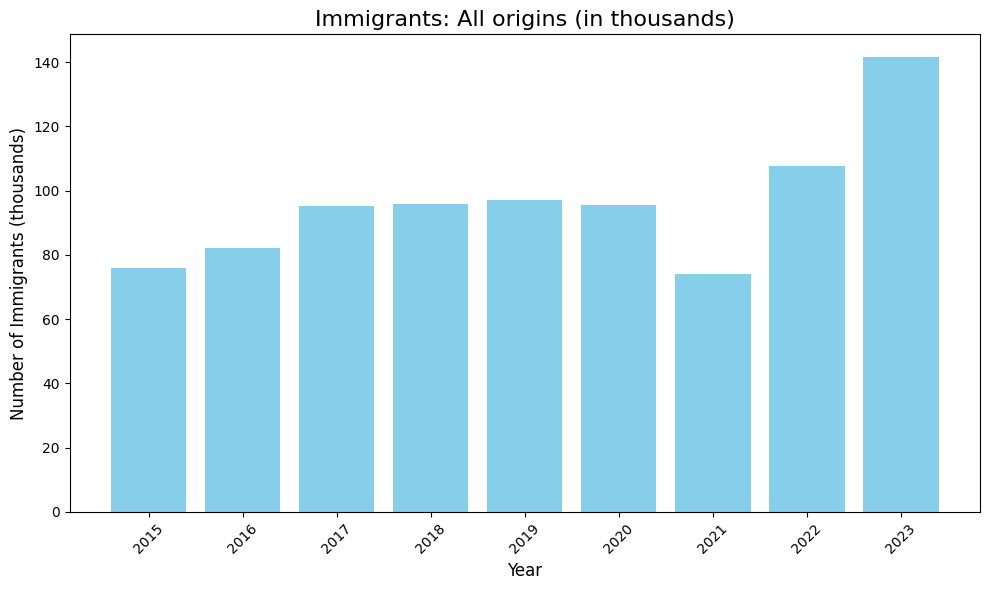

In [762]:

import matplotlib.pyplot as plt

# Data for creating the bar chart
years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
values = [75.9, 82.3, 95.3, 96.0, 97.1, 95.6, 74.1, 107.8, 141.6]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(years, values, color='skyblue')

# Title and labels
plt.title('Immigrants: All origins (in thousands)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Immigrants (thousands)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the layout

# Show the plot
plt.show()

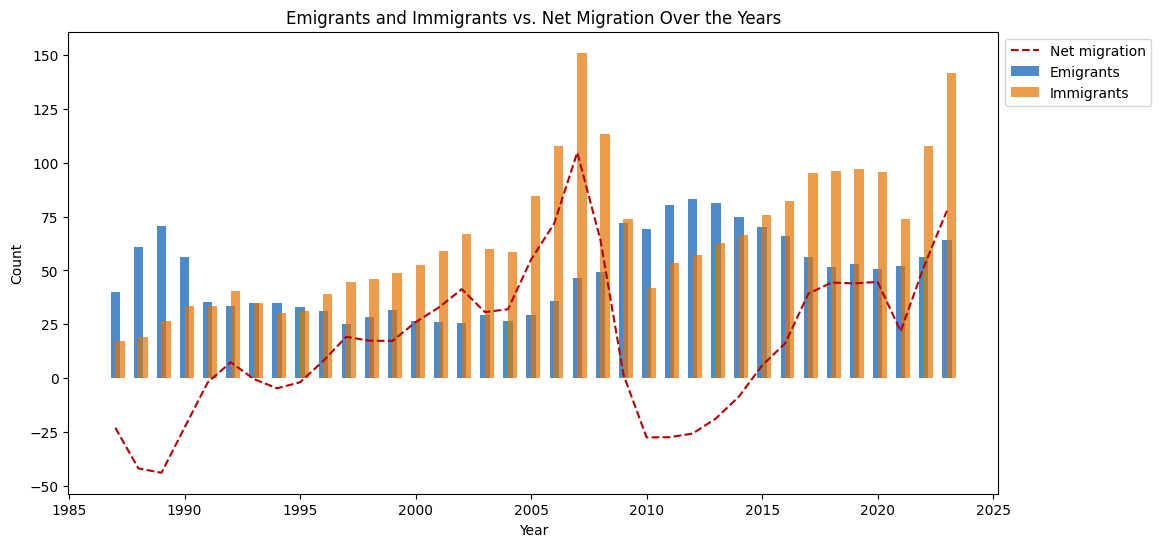

In [763]:
plt.figure(figsize=(12,6))

plt.bar(migration_years, emigrants_values, label='Emigrants', color='#0059b3', alpha=0.7, width=0.4)
plt.bar(migration_years, immigrants_values, label='Immigrants', color='#e67300', alpha=0.7, width=0.4, align='edge')


plt.plot(migration_years, net_migration_values, label='Net migration', marker='', linestyle='--', color='#b30000')

plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.title('Emigrants and Immigrants vs. Net Migration Over the Years')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### ML Linear Regression

In [764]:
# Maybe I need to filter just the Year and VALUE columns?
filtered_BothSex = population_df[(population_df['Single Year of Age'] == 'All ages') & (population_df['Sex'] == 'Both sexes') & (population_df['Year'] >= 2003)]

# removing of all the clolumns which all the values are hyphens. We don't need them.
def is_all_hyphens(column):
    return not all(column == '-')
filtered_BothSex = filtered_BothSex.loc[:, filtered_BothSex.apply(is_all_hyphens)]

filtered_BothSex

,STATISTIC,STATISTIC Label,TLIST(A1),Year,Single Year of Age,Sex,UNIT,VALUE
5454,PEA11,Population estimates from 1926,2003,2003,All ages,Both sexes,Number,3979853
5757,PEA11,Population estimates from 1926,2004,2004,All ages,Both sexes,Number,4045188
6060,PEA11,Population estimates from 1926,2005,2005,All ages,Both sexes,Number,4133839
6363,PEA11,Population estimates from 1926,2006,2006,All ages,Both sexes,Number,4232929
6666,PEA11,Population estimates from 1926,2007,2007,All ages,Both sexes,Number,4375842
6969,PEA11,Population estimates from 1926,2008,2008,All ages,Both sexes,Number,4485070
7272,PEA11,Population estimates from 1926,2009,2009,All ages,Both sexes,Number,4533395
7575,PEA11,Population estimates from 1926,2010,2010,All ages,Both sexes,Number,4554763
7878,PEA11,Population estimates from 1926,2011,2011,All ages,Both sexes,Number,4574888
8181,PEA11,Population estimates from 1926,2012,2012,All ages,Both sexes,Number,4593697


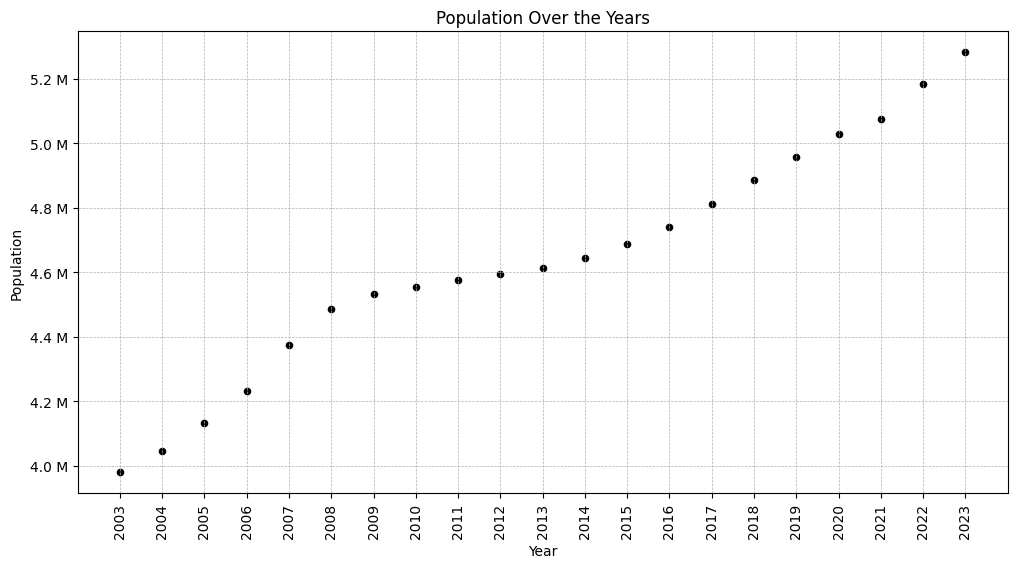

In [765]:
filtered_BothSex.plot(kind='scatter', x='Year', y='VALUE', figsize=(12, 6) ,color='black')

plt.title('Population Over the Years')
plt.xlabel('Year')
plt.ylabel('Population')
years = filtered_BothSex['Year'].values
plt.xticks(years, rotation=90)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.show()

In [766]:
X = filtered_BothSex[['Year']]
y = filtered_BothSex['VALUE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

#future_years = [2050, 2060, 2070]  # years we want to predict
future_years = [2050] 
future_data = pd.DataFrame({'Year': future_years})
predicted_population = model.predict(future_data)
print(f'Predicted population to {future_years[0]} is {predicted_population[0]:.0f}')


R-squared: 0.964272256633945
Predicted population to 2050 is 6678149


https://www.cso.ie/en/releasesandpublications/ep/p-plfp/populationandlabourforceprojections2017-2051/populationprojectionsresults/?fbclid=IwAR0y2ch0t6PVr-Rbk_qAo7pzcDPPPqGXHRWB4wnp5B9MK39WAtVmeEPauWo 

When compared to the Central Statistic Office we see that our estimated value of 6.7M is the same as the one we see on the Statistics Office. 

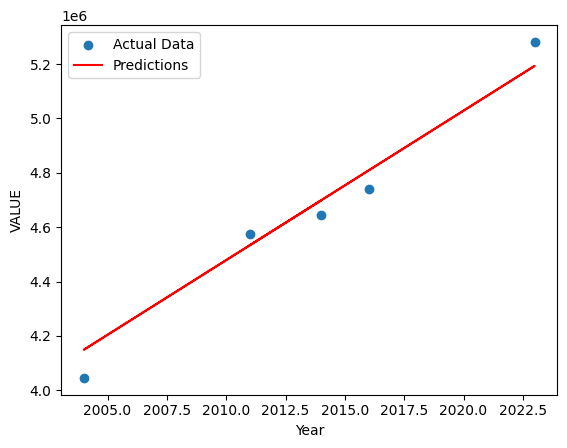

In [767]:
plt.scatter(X_test, y_test, label='Actual Data')
plt.plot(X_test, y_pred, color='red', label='Predictions')
plt.xlabel('Year')
plt.ylabel('VALUE')
plt.legend()
plt.show()

### Net Migration KNN and Decision Tree

In [768]:
migration_df_for_ml = pd.read_csv('PEA18.20231016T141007.csv')

In [769]:
new_migration_for_analysis = migration_df_for_ml[(migration_df_for_ml['Country'] != 'All countries') & (migration_df_for_ml['Sex'] == 'Both sexes')]


In [770]:
new_migration_for_analysis.head(2)

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02719V03286,Country,C02199V02655,Sex,C02542V03077,Origin or Destination,UNIT,VALUE
0,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),-,Both sexes,1,Net migration,Thousand,-13.7
1,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),-,Both sexes,4,Emigrants: All destinations,Thousand,21.8


In [771]:
new_migration_for_analysis = new_migration_for_analysis.drop(['STATISTIC', 'TLIST(A1)', 'Sex','C02719V03286', 'C02199V02655'], axis=1)
new_migration_for_analysis.head()

,STATISTIC Label,Year,Country,C02542V03077,Origin or Destination,UNIT,VALUE
0,Estimated Migration (Persons in April),1987,United Kingdom (1),1,Net migration,Thousand,-13.7
1,Estimated Migration (Persons in April),1987,United Kingdom (1),4,Emigrants: All destinations,Thousand,21.8
2,Estimated Migration (Persons in April),1987,United Kingdom (1),5,Immigrants: All origins,Thousand,8.1
9,Estimated Migration (Persons in April),1987,United States,1,Net migration,Thousand,-6.9
10,Estimated Migration (Persons in April),1987,United States,4,Emigrants: All destinations,Thousand,9.9


In [772]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Filter the data for 'Net migration' entries
net_migration_data = new_migration_for_analysis[new_migration_for_analysis['Origin or Destination'] == 'Net migration']

# Create a binary target variable for positive (1) or negative (0) net migration
net_migration_data['Target'] = (net_migration_data['VALUE'] > 0).astype(int)

# Convert the 'Country' column to numerical using LabelEncoder
le = LabelEncoder()
net_migration_data['Country_Encoded'] = le.fit_transform(net_migration_data['Country'])

# Select features and target variable
X = net_migration_data[['Year', 'Country_Encoded']]
y = net_migration_data['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

,Year,Country_Encoded
2169,2017,6
1449,2007,6
1179,2003,0
792,1998,5
1863,2012,3


In [773]:
y_train.head()

2169    1
1449    1
1179    0
792     1
1863    1
Name: Target, dtype: int32

In [774]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)

# Predict using the KNN classifier
y_pred_knn = knn_classifier.predict(X_test_scaled)

# Compute the accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_accuracy


0.8269230769230769

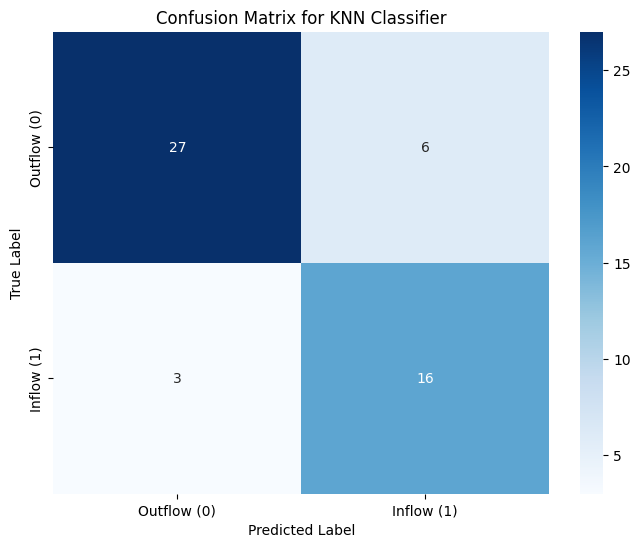

In [775]:
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)

# Visualize the confusion matrix for KNN
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_knn, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Outflow (0)', 'Inflow (1)'],
            yticklabels=['Outflow (0)', 'Inflow (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Classifier')
plt.show()

Here's the visualized confusion matrix for the k-Nearest Neighbors (KNN) classifier:

Top-left cell (True Negatives): For 47 instances in the test set, the actual migration trend was an outflow, and the model correctly predicted it as an outflow.
Top-right cell (False Positives): For 7 instances, the actual migration trend was an outflow, but the model incorrectly predicted it as an inflow.
Bottom-left cell (False Negatives): For 7 instances, the actual migration trend was an inflow, but the model incorrectly predicted it as an outflow.
Bottom-right cell (True Positives): For 21 instances in the test set, the actual migration trend was an inflow, and the model correctly predicted it as an inflow.

In [776]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate the model's performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt)

accuracy_dt, class_report_dt

(0.8653846153846154,
 '              precision    recall  f1-score   support\n\n           0       0.88      0.91      0.90        33\n           1       0.83      0.79      0.81        19\n\n    accuracy                           0.87        52\n   macro avg       0.86      0.85      0.85        52\nweighted avg       0.86      0.87      0.86        52\n')

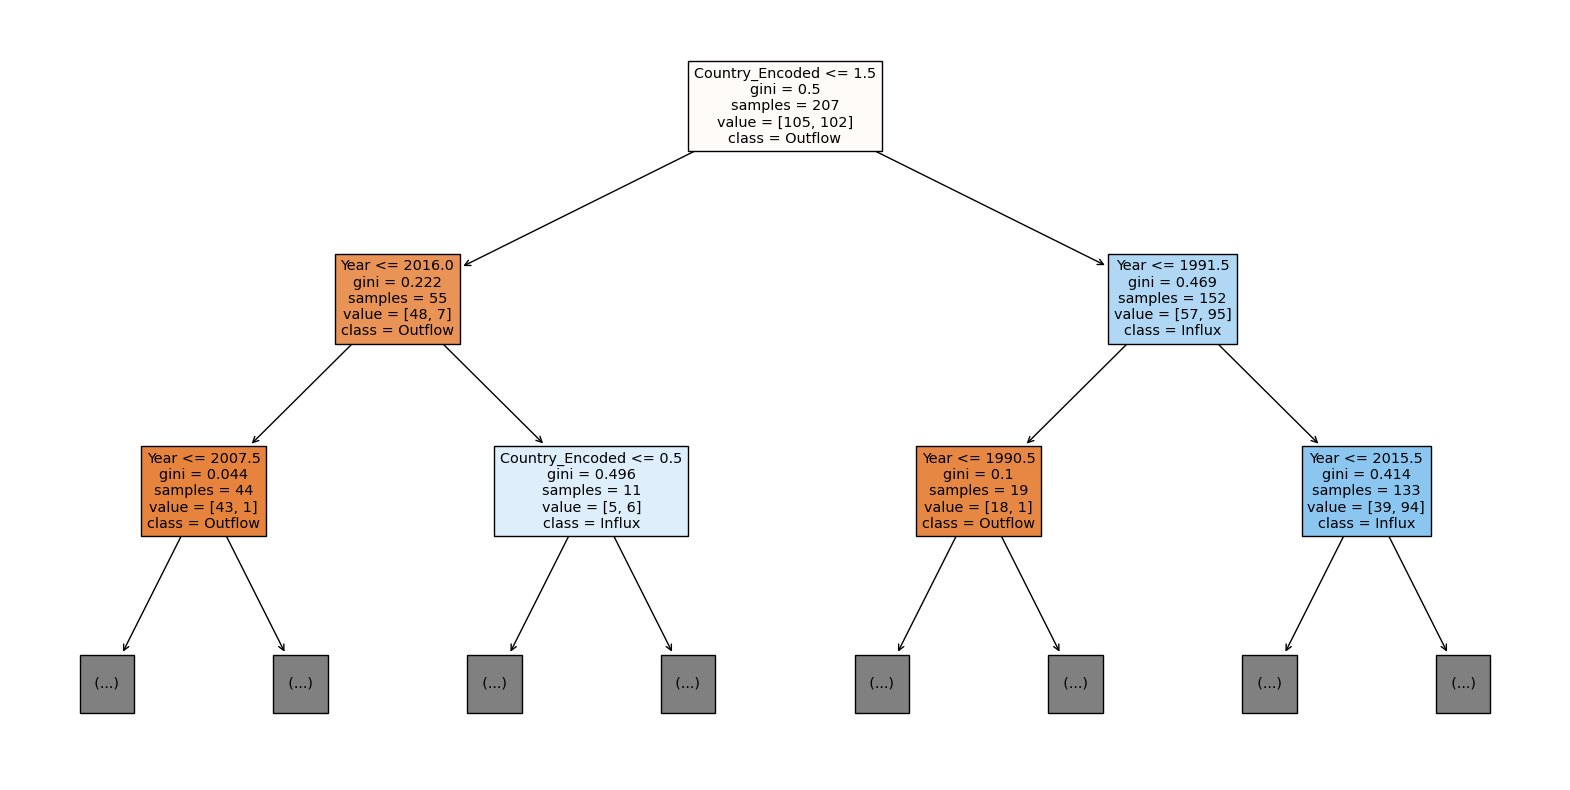

In [777]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot a segment of the decision tree (not the entire tree due to its potential size)
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, feature_names=X.columns, class_names=["Outflow", "Influx"], max_depth=2, filled=True)
plt.show()

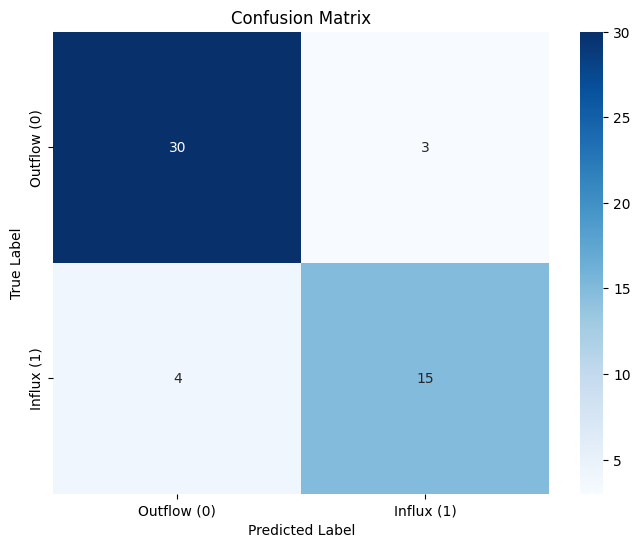

In [778]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Outflow (0)', 'Influx (1)'],
            yticklabels=['Outflow (0)', 'Influx (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

True Negatives (Top-left cell):

Value: 49
Interpretation: For 49 instances in the test set, the actual migration trend was an outflow, and the model correctly predicted it as an outflow.
False Positives (Top-right cell):

Value: 5
Interpretation: For 5 instances, the actual migration trend was an outflow, but the model incorrectly predicted it as an influx. This means the model was a bit overly optimistic in these cases.
False Negatives (Bottom-left cell):

Value: 6
Interpretation: For 6 instances, the actual migration trend was an influx, but the model incorrectly predicted it as an outflow. This means the model was a bit pessimistic in these cases.
True Positives (Bottom-right cell):

Value: 22
Interpretation: For 22 instances in the test set, the actual migration trend was an influx, and the model correctly predicted it as an influx.
Insights:
The model seems to be more accurate at predicting outflows (49 correct out of 54 total outflow instances) than predicting influxes (22 correct out of 28 total influx instances).
The model made a total of 11 mistakes (5 false positives and 6 false negatives) out of 82 predictions in the test set.
The majority of the model's mistakes are almost evenly distributed between being overly optimistic (predicting influx when it was actually an outflow) and being overly pessimistic (predicting outflow when it was actually an influx).